<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D3/tutorials/W3D3_NetworkCausality/W3D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2020: Week 3 Day 3, Tutorial 1

# Causality Day: Interventions


#Tutorial Objectives

We list our overall day objectives below, with the sections we will focus on in this notebook in bold:

1.   **Master definitions of causality**
2.   **Understand that estimating causality is possible**
3.   Learn 5 different methods and understand when they fail
    1. **perturbations**
    2. correlations
    3. simultaneous fitting/regression
    4. Granger causality
    5. instrumental variables

### Tutorial setting

The methods we'll learn are very general. 

They apply to analyzing fMRI data: **when is functional connectivity causal connectivity**?

They apply to sensory analyses: **what about stimuli causes neurons to spike?**

They apply to motor control: **How does this brain area cause changes in movement?**

Causal questions are everywhere!


### Tutorial 1 Objectives:

1.   Simulate a system we can discuss
2.   Understand perturbation as a method of estimating causality


# Setup

In [1]:
import matplotlib.pyplot as plt # import plotting modules
import numpy as np              # import numpy for matrix manipulation

In [2]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [3]:
#@title Helper functions

def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def create_connectivity(n_neurons, random_state=42):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0,1], size=(n_neurons, n_neurons), p=[0.9, 0.1])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals , _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0]) 

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A

def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0,np.pi*2,n,endpoint=False )
    x,y = np.cos(thetas),np.sin(thetas),
    ax.scatter(x,y,c='k',s=150)
    #renormalize
    A = A / A.max()
    for i in range(n):
        for j in range(n):
            if A[i,j]>0:
                ax.arrow(x[i],y[i],x[j]-x[i],y[j]-y[i],color='k',alpha=A[i,j],head_width=.15,
                        width = A[i,j]/25,shape='right', length_includes_head=True)
    ax.axis('off')

def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap."""
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")


---

# Defining and estimating causality

Let's think carefully about the statement "**A causes B**". To be concrete, let's take two neurons. What does it mean to say that neuron $A$ causes neuron $B$ to fire?

The *interventional* definition of causality says that:
$$
(A \text{ causes } B) \Leftrightarrow ( \text{ If we force }A \text { to be different, then }B\text{ changes})
$$

To determine if $A$ causes $B$ to fire, we can inject current into neuron $A$ and see what happens to $B$.

**A mathematical definition of causality**: 
Over many trials, the average causal effect $\delta_{A\to B}$ of neuron $A$ upon neuron $B$ is the average change in neuron $B$'s activity when we set $A=1$ versus when we set $A=0$.


$$
\delta_{A\to B} = \mathbb{E}[B | A=1] -  \mathbb{E}[B | A=0] 
$$

Note that this is an average effect. While one can get more sophisticated about conditional effects ($A$ only effects $B$ when it's not refractory, perhaps), today we will only consider average effects.

**Relation to a randomized controlled trial (RCT)**:
The logic we just described is the logic of a randomized control trial (RCT). If you randomly give 100 people a drug and 100 people a placebo, the effect is the difference in outcomes.



## Exercise 1 (Warm-up): a randomized controlled trial for two neurons

Let's actually code that out. 

**Setting**: Neuron $A$ synapses on Neuron $B$

**Goal**: Perturb $A$ and confirm that $B$ changes. 

Let's have that $B = A + \epsilon$, where $\epsilon$ is standard normal noise $\epsilon\sim\mathcal{N}(0,1)$.

In [4]:
def neuron_B(activity_of_A):
  """Model activity of neuron B as neuron A activity + noise

  Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A

  Returns:
    ndarray: activity of neuron B
  """
  noise = np.random.randn(*activity_of_A.shape)
  return activity_of_A + noise

# Neuron A activity of zeros
A_0 = np.zeros(5000)

# Neuron A activity of ones
A_1 = np.ones(5000)

###########################################################################
## TODO for students: Estimate the causal effect of A upon B by getting the 
## difference in mean of B when A=0 vs. A=1
###########################################################################

# diff_in_means = 
# print(diff_in_means)

In [5]:
# to_remove solution
def neuron_B(activity_of_A):
  """Model activity of neuron B as neuron A activity + noise

  Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A

  Returns:
    ndarray: activity of neuron B
  """
  noise = np.random.randn(*activity_of_A.shape)
  return activity_of_A + noise

A_0 = np.zeros(5000)
A_1 = np.ones(5000)

diff_in_means = neuron_B(A_1).mean() - neuron_B(A_0).mean()
print(diff_in_means) 

0.9943048175385746


The result should be close to $1$. Is this what you get?

# Simulating a system of neurons



Video available at https://youtu.be/3oHhuzUZRfA


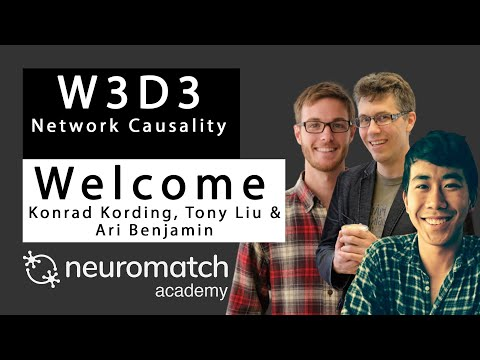

In [6]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="3oHhuzUZRfA", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Can we still estimate causal effects when the neurons are in big networks? This is the main question we will ask today. Let's first create our system, and the rest of today will be spend analyzing it.

## Today's model

Our system has N interconnected neurons that affect each other over time. Each neuron at time $t+1$ is a function of the activity of the other neurons from the previous time $t$. 

Neurons affect each other with a linear function with added noise, which is then passed through a nonlinearity:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

- $\vec{x}_t$ is an $n$-dimensional vector representing our $n$-neuron system at timestep $t$
- $\sigma$ is a sigmoid nonlinearity
- $A$ is our $n \times n$ *causal ground truth connectivity matrix* (more on this later)
- $\epsilon_t$ is random noise: $\epsilon_t \sim N(\vec{0}, I_n)$
- $\vec{x}_0$ is initialized to $\vec{0}$

### Notes on $A$

$A$ is a connectivity matrix, so the element $A_{ij}$ represents the causal effect of neuron $i$ on neuron $j$. 

We'll set it up so that neurons on average receive connections from only 10% of the whole population.


## Visualize  true connectivity

We will create a connectivity matrix between 6 neurons and visualize it in two different ways: as a graph with directional edges between connected neurons and as an image of the connectivity matrix

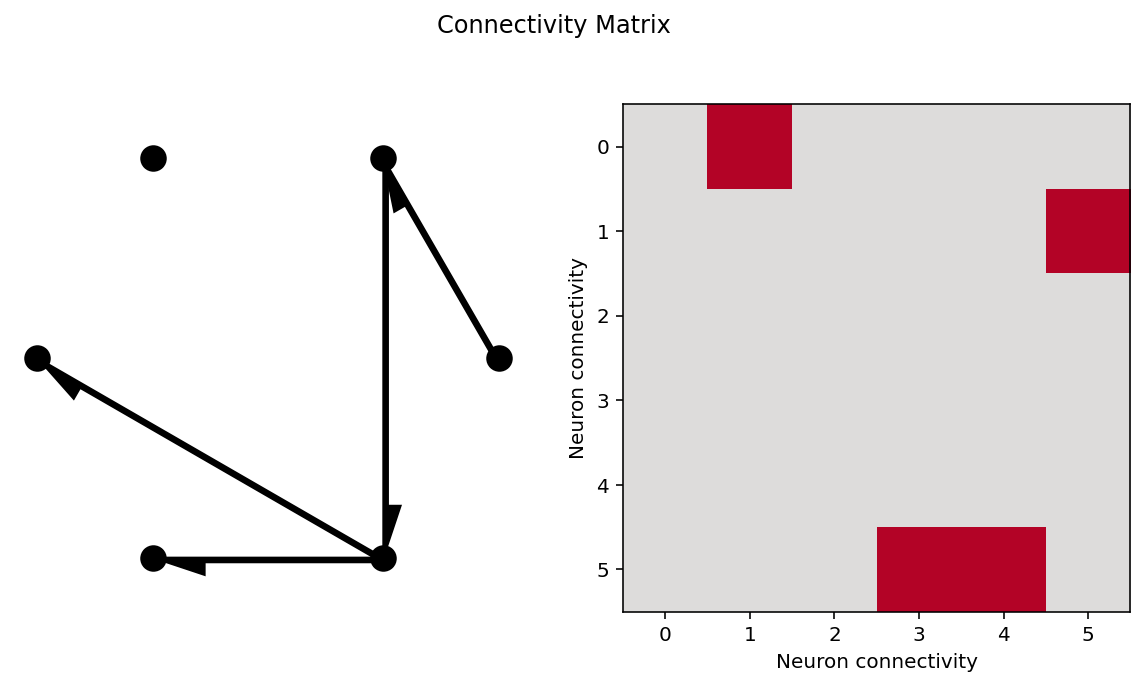

In [7]:
## Intializes the system
n_neurons = 6  
A = create_connectivity(n_neurons) # we are invoking a helper function that generates our nxn causal connectivity matrix.

# Let's plot it!
fig, axs = plt.subplots(1,2, figsize=(10,5)) 
see_neurons(A,axs[0]) # we are invoking a helper function that visualizes the connectivity matrix
plot_connectivity_matrix(A)
plt.xlabel("Neuron connectivity")
plt.ylabel("Neuron connectivity")
fig.suptitle("Connectivity Matrix")

plt.show()

## Exercise 2: System Simulation

In this exercise we're going to simulate the system. Please complete the following function so that at every timestep the activity vector $x$ is updated according to:
$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t).
$$
Make sure your noise is N-dimensional, with one element per neuron.

In [8]:
def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
        
    Returns:
        - X has shape (n_neurons, timeteps). A schematic:
                   ___t____t+1___
                  |   0    1     |
                  |   1    0     |
       n_neurons  |   0 -> 1     |
                  |   0    0     |
                  |___1____0_____|

    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps-1):
        ########################################################################
        ## TODO: Fill in the update rule for our dynamical system.
        ## Function Hints:
        ##   epsilon: multivariate normal with mean zero and unit variance -> 
        ##   np.random.multivariate_normal(np.zeros(n), np.eye(n_neurons))
        ## Fill in function and remove
        raise NotImplementedError("Please make the dynamical system.")
        ########################################################################
        
        epsilon = ...
        X[:, t+1] = sigmoid(A.dot(...) + epsilon) # we are using helper function sigmoid

        assert epsilon.shape == (n_neurons,)
    return X

## Uncomment to test it
# timesteps = 5000 # Simulate for 5000 timesteps.

# # Simulate our dynamical system for the given amount of time
# X = simulate_neurons(A, timesteps)

# f, ax = plt.subplots()
# ax.imshow(X[:,:10])
# ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')

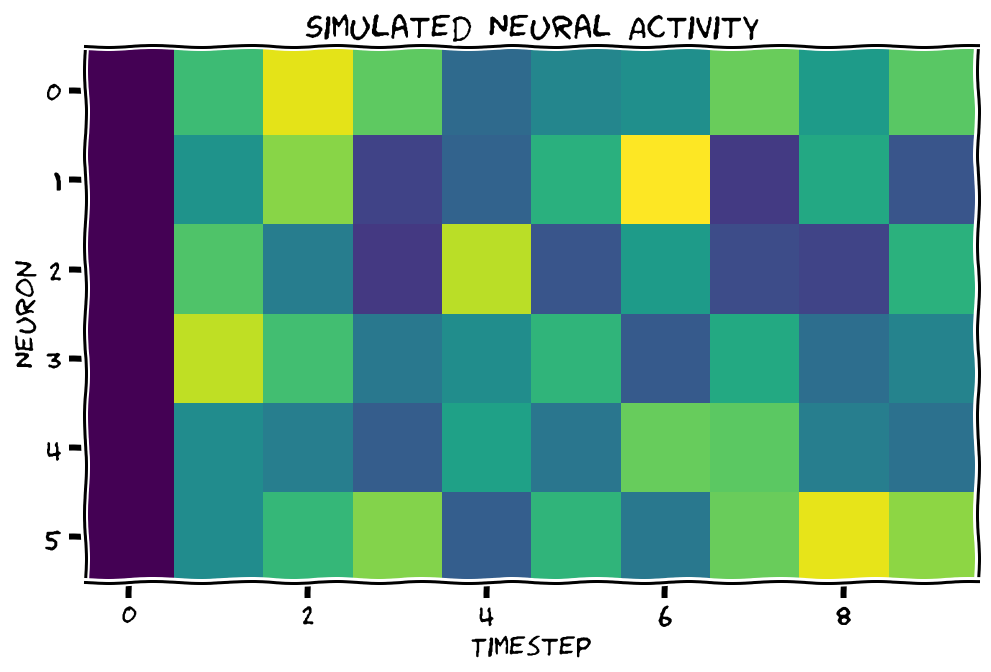

In [9]:
# to_remove solution
def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
        
    Returns:
        - X has shape (n_neurons, timeteps). A schematic:
                   ___t____t+1___
                  |   0    1     |
                  |   1    0     |
       n_neurons  |   0 -> 1     |
                  |   0    0     |
                  |___1____0_____|

    """
    np.random.seed(random_state)
    
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps-1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t+1] = sigmoid(A.dot(X[:,t]) + epsilon) # we are using helper function sigmoid

        assert epsilon.shape == (n_neurons,)
    return X

### Now test it
timesteps = 5000 # Simulate for 5000 timesteps.

# Simulate our dynamical system for the given amount of time
X = simulate_neurons(A, timesteps)
with plt.xkcd():
  f, ax = plt.subplots()
  ax.imshow(X[:,:10])
  ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')

# Recovering connectivity through perturbation

Video available at https://youtu.be/zlRhaGBzkug


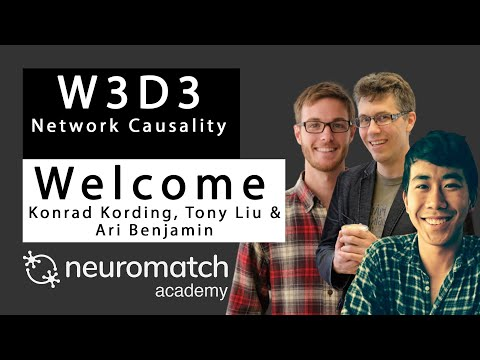

In [10]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="zlRhaGBzkug", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


## Random perturbation in our system of neurons

We want to get the causal effect of each neuron upon each other neuron. The ground truth of the causal effects is the connectivity matrix $A$.

Remember that we would like to calculate:
$$
\delta_{A\to B} = \mathbb{E}[B | A=1] -  \mathbb{E}[B | A=0] 
$$


We'll do this by randomly setting the system state to 0 or 1 and observing the outcome after one timestep. If we do this $N$ times, the effect of neuron $i$ upon neuron $j$ is:
$$
\delta_{x^i\to x^j} \approx \frac1N \sum_i^N[x_{t+1}^j | x^i_t=1] -  \frac1N \sum_i^N[x_{t+1}^j | x^i_t=0]] 
$$
This is just the average difference of the activity of neuron $j$ in the two conditions.

**Coding strategy**: We are going to calculate the above equation, but imagine it like *intervening* in activity every other timestep.

In [11]:
def simulate_neurons_perturb(A, timesteps, perturb_freq=2):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps,
    BUT every other timestep the activity is clamped to a random pattern of 1s and 0s

    Args:
        A (np.array): the true connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        perturb_freq (int): the perturbation frequency (2 means perturb every other timestep)
        random_state (int): random seed for reproducibility
        
    Returns:
        The results of the simulated system.
        - X has shape (n_neurons, timeteps)
    """
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps-1):
      
        if t % perturb_freq == 0:
            X[:,t] = np.random.choice([0,1], size=n_neurons)
        
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t+1] = sigmoid(A.dot(X[:,t]) + epsilon) # we are using helper function sigmoid

    return X

Take a look at the the update equation. While the rest of the function is the same as the ``simulate_neurons`` function in the previous exercise, every time step we now additionally include:
```
if t % perturb_freq == 0:
    X[:,t] = np.random.choice([0,1], size=n_neurons)
```
Pretty serious perturbation, huh? You don't want that going on in your brain.

**Now visually compare the dynamics:** Run this next cell and see if you can spot how the dynamics have changed.

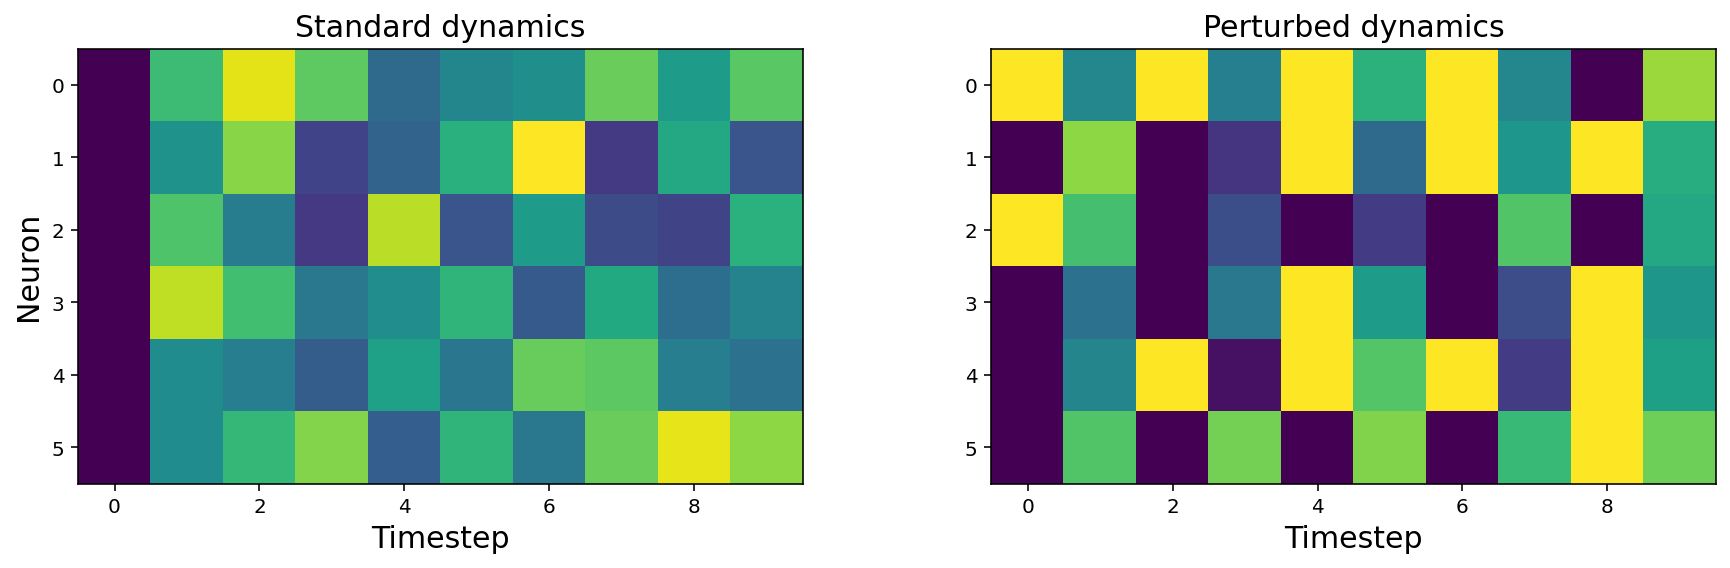

In [12]:
timesteps = 5000 # Simulate for 5000 timesteps.

# Simulate our dynamical system for the given amount of time
X_perturbed = simulate_neurons_perturb(A, timesteps)

# Plot our standard versus perturbed dynamics
fig, axs = plt.subplots(1,2, figsize=(15,4)) 
axs[0].imshow(X[:,:10])
axs[1].imshow(X_perturbed[:,:10])
axs[0].set_ylabel("Neuron",fontsize=15)
axs[1].set_xlabel("Timestep",fontsize=15)
axs[0].set_xlabel("Timestep",fontsize=15);
axs[0].set_title("Standard dynamics",fontsize=15)
axs[1].set_title("Perturbed dynamics",fontsize=15);

## Exercise 3: Using perturbed dynamics to recover connectivity

From the above perturbed dynamics, write a function that recovers the causal effect of all neurons upon a single neuron chosen. Remember from above you're calculating:
$$
\delta_{x^i\to x^j} \approx \frac1N \sum_i^N[x_{t+1}^j | x^i_t=1] -  \frac1N \sum_i^N[x_{t+1}^j | x^i_t=0]] 
$$

We wrote a code skeleton for you. It iterates through all neurons and gets the effect of `neuron_idx` upon `selected_neuron`.

In [13]:
def get_perturbed_connectivity_single_neuron(perturbed_X, perturb_freq, selected_neuron):
    """
    Computes the connectivity matrix for the selected neuron using differences in means.

    Args:
        perturbed_X (np.ndarray): the perturbed dynamical system matrix of shape (n_neurons, timesteps)
        perturb_freq (int): the perturbation frequency (2 means perturb every other timestep)
        selected_neuron (int): the index of the neuron we want to estimate connectivity for

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """
    neuron_perturbations = perturbed_X[selected_neuron, ::perturb_freq] # extract the perturbations of neuron 1
    all_neuron_output = perturbed_X[:, 1::perturb_freq] # extract the observed outcomes of all the neurons

    estimated_connectivity = np.zeros(n_neurons) # our stored estimated connectivity matrix

    for neuron_idx in range(n_neurons):
        selected_neuron_output = all_neuron_output[neuron_idx, :]
        one_idx = np.argwhere(neuron_perturbations == 1)
        zero_idx = np.argwhere(neuron_perturbations == 0)

        ########################################################################
        ## TODO: Insert your code here to compute the neuron activation from perturbations.
        ## Recall from above that this is E[Y | T=1] - E[Y | T=0].
        ## Y in this case is selected_neuron_output.
        ## T=1 and T=0 in this case are one_idx and zero_idx, respectively.
        ##
        ## Function Hints:
        ##     expected value -> np.mean()

        # Fill out function and remove
        raise NotImplementedError("Complete the exercise of causal effects")
        ########################################################################
        
        difference_in_means = ...

        estimated_connectivity[neuron_idx] = difference_in_means

    return estimated_connectivity


# ## Uncomment to test
# # Initialize the system
# n_neurons = 6  
# timesteps = 5000 # Simulate for 5000 timesteps.
# perturb_freq = 2 # perturb the system every other time step

# # Simulate our perturbed dynamical system for the given amount of time
# perturbed_X = simulate_neurons_perturb(A, timesteps, perturb_freq=perturb_freq)

# # we'll measure the connectivity of neuron 1
# selected_neuron = 1
# estimated_connectivity = get_perturbed_connectivity_single_neuron(perturbed_X, perturb_freq, selected_neuron)

# #Now plot
# fig, axs = plt.subplots(1,2, figsize=(10,5)) 
# plot_connectivity_matrix(np.expand_dims(estimated_connectivity, axis=1), ax=axs[0])
# axs[0].set(title="Estimated connectivity", ylabel="Neuron")
# plot_connectivity_matrix(A[:, [selected_neuron]], ax=axs[1])
# axs[1].set(title="True connectivity")

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


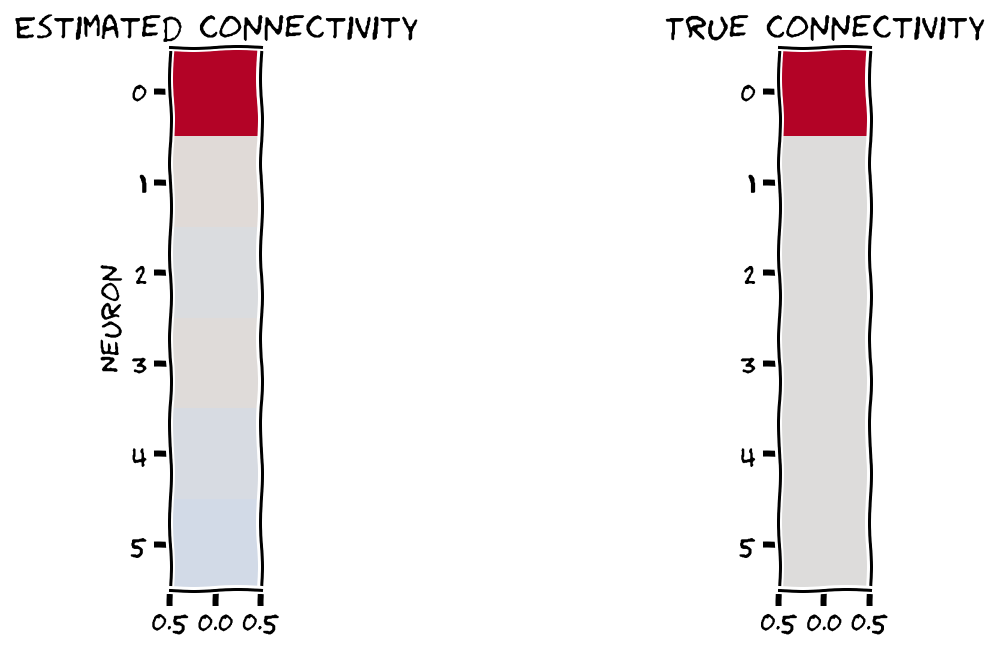

In [14]:
# to_remove solution
def get_perturbed_connectivity_single_neuron(perturbed_X, perturb_freq, selected_neuron):
    """
    Computes the connectivity matrix for the selected neuron using differences in means.

    Args:
        perturbed_X (np.ndarray): the perturbed dynamical system matrix of shape (n_neurons, timesteps)
        perturb_freq (int): the perturbation frequency (2 means perturb every other timestep)
        selected_neuron (int): the index of the neuron we want to estimate connectivity for

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """
    neuron_perturbations = perturbed_X[selected_neuron, ::perturb_freq] # extract the perturbations of neuron 1
    all_neuron_output = perturbed_X[:, 1::perturb_freq] # extract the observed outcomes of all the neurons

    estimated_connectivity = np.zeros(n_neurons) # our stored estimated connectivity matrix

    for neuron_idx in range(n_neurons):
        selected_neuron_output = all_neuron_output[neuron_idx, :]
        one_idx = np.argwhere(neuron_perturbations == 1)
        zero_idx = np.argwhere(neuron_perturbations == 0)

        difference_in_means = np.mean(selected_neuron_output[one_idx]) - np.mean(selected_neuron_output[zero_idx])

        estimated_connectivity[neuron_idx] = difference_in_means

    return estimated_connectivity

# Initialize the system
n_neurons = 6  
timesteps = 5000 # Simulate for 5000 timesteps.
perturb_freq = 2 # perturb the system every other time step

# Simulate our perturbed dynamical system for the given amount of time
perturbed_X = simulate_neurons_perturb(A, timesteps, perturb_freq=perturb_freq)

# we'll measure the connectivity of neuron 1
selected_neuron = 1
estimated_connectivity = get_perturbed_connectivity_single_neuron(perturbed_X, perturb_freq, selected_neuron)

#Now plot
with plt.xkcd():
  fig, axs = plt.subplots(1,2, figsize=(10,5))
  plot_connectivity_matrix(np.expand_dims(estimated_connectivity, axis=1), ax=axs[0])
  axs[0].set(title="Estimated connectivity", ylabel="Neuron")
  plot_connectivity_matrix(A[:, [selected_neuron]], ax=axs[1])
  axs[1].set(title="True connectivity")

Let's quantify how close these two are by correlating the estimated and true connectivity matrices:

In [15]:
# We should see almost perfect correlation between our estimates and the true connectivity
np.corrcoef(A[:, selected_neuron], estimated_connectivity)[1,0]

0.9960188025389387

## Measuring how perturbations recover the entire connectivity matrix

Nice job! You just estimated connectivity for a single neuron.

We're now going to use the same strategy for all neurons at once. We coded up this function for you. Don't worry about how it works. (If you're curious and have extra time, scroll to the explanation at the bottom).


In [16]:
#@title Define perturbation estimator for all neurons
def get_perturbed_connectivity_all_neurons(perturbed_X, perturb_freq):
    """
    Estimates the connectivity matrix of perturbations through stacked correlations.

    Args:
        perturbed_X (np.ndarray): the simulated dynamical system X of shape (n_neurons, timesteps) 
        perturb_freq (int): the perturbation frequency (2 means perturb every other timestep)

    Returns:
        R (np.ndarray): the estimated connectivity matrix of shape (n_neurons, n_neurons)
    """
    # select perturbations (P) and outcomes (O)
    P = perturbed_X[:, ::perturb_freq]
    O = perturbed_X[:, 1::perturb_freq]

    # stack perturbations and outcomes into a 2n by (timesteps / 2) matrix
    S =  np.concatenate([P, O], axis=0)

    # select the perturbation -> outcome block of correlation matrix (upper right)
    R = np.corrcoef(S)[:n_neurons, n_neurons:]

    return R

In [17]:
# Initializes the system
n_neurons = 6  
A = create_connectivity(n_neurons) # we are invoking a helper function that generates our nxn causal connectivity matrix.

timesteps = 5000 # Simulate for 5000 timesteps.
perturb_freq = 2 # perturb the system every other time step

# Simulate our perturbed dynamical system for the given amount of time
perturbed_X = simulate_neurons_perturb(A, timesteps, perturb_freq)

# Get our estimated connectivity matrix
R = get_perturbed_connectivity_all_neurons(perturbed_X, perturb_freq)

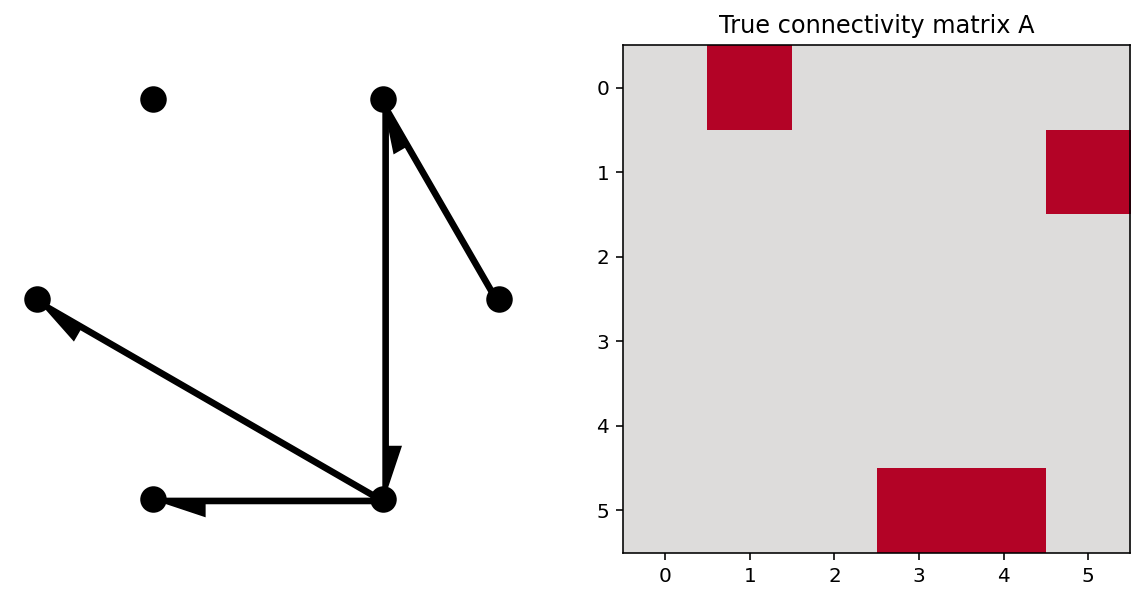

Text(0.5, 1.0, 'Estimated connectivity matrix R')

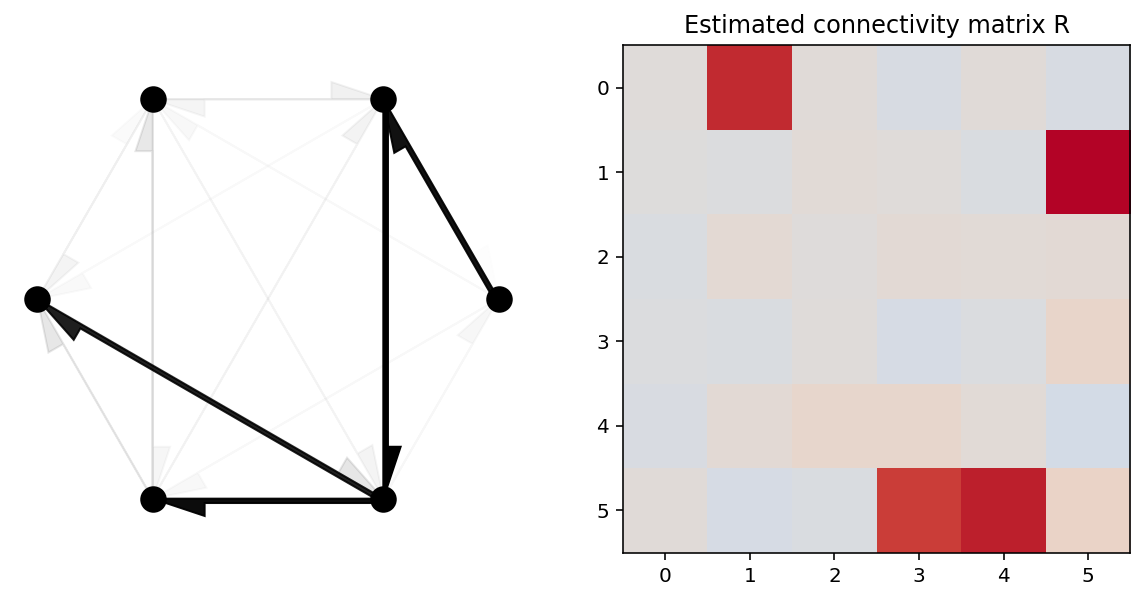

In [18]:
# Let's visualize the true connectivity and estimated connectivity together
fig, axs = plt.subplots(1,2, figsize=(10,5)) 
see_neurons(A, axs[0]) # we are invoking a helper function that visualizes the connectivity matrix
plot_connectivity_matrix(A, ax=axs[1])
plt.title("True connectivity matrix A")
plt.show()
fig, axs = plt.subplots(1,2, figsize=(10,5)) 
see_neurons(R.T,axs[0]) # we are invoking a helper function that visualizes the connectivity matrix
plot_connectivity_matrix(R.T, ax=axs[1])
plt.title("Estimated connectivity matrix R")

**Quantifying success**: We can calculate the correlation coefficient between the elements of the two matrices 

In [19]:
np.corrcoef(A.transpose().flatten(), R.flatten())[1,0]

0.987593404378358

We do a good job recovering the true causality of the system!

## Optional Note: how we compute the estimated connectivity matrix

**This is an optional explanation of what the code is doing in `connectivity_from_perturbed_simulation()`**

First, we compute an estimated connectivity matrix $R$. We extract
perturbation matrix $P$ and outcomes matrix $O$:

$$
P = \begin{bmatrix}
\mid & \mid & ... & \mid \\ 
x_0  & x_2  & ... & x_T  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times T/2}
$$

$$
O = \begin{bmatrix}
\mid & \mid & ... & \mid \\ 
x_1  & x_3  & ... & x_{T-1}  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times T/2}
$$

And calculate the correlation of matrix $S$, which is $P$ and $O$ stacked on each other:

$$
S = \begin{bmatrix}
P  \\ 
O
\end{bmatrix}_{2n \times T/2}
$$

We then extract $R$ as the upper right $n \times n$ block of $corr(S)$:


This is because the upper right block corresponds to the estimated perturbation effect on outcomes for each pair of neurons in our system.

# Summary

In this tutorial, we learned about how to define and estimate causality using pertubations. In particular we:

1) Learned how to simulate a system of connected neurons

2) Learned how to estimate the connectivity between neurons by directly perturbing neural activity